In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

In [ ]:
# LICENSE
# This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The U.S. Government has granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare derivative works, distribute copies to the public, perform publicly, display publicly, and to permit others to do so.

#Permission is granted to the public to copy, use, modify, and distribute this material without charge, provided that the Notice in its entirety, including without limitation the statement of reserved government rights, are reproduced on all copies.

## Load data

In [1]:
# Copy results of NF here
import subprocess

# import data files

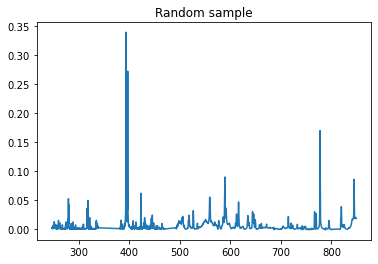

(426, 5606)

In [3]:
# Get calibration samples and labels 

# Load observations
file = np.load('data/NF_mixed_train_test_data.npz')  
calib_data = file['y_calib'] # get earth data after earth_2_mars transform


# Load wavelengths
w = file['w']
rr = np.random.randint(0,426)
plt.plot(w, calib_data[rr,:])
plt.title('Random sample')
plt.show()
calib_data.shape

In [92]:
# Load wavelengths separately
file100 = np.load('data/calibration_data_subset.npz')
wav_uv = file100['w1']
wav_vio = file100['w2']
wav_vnir = file100['w3']

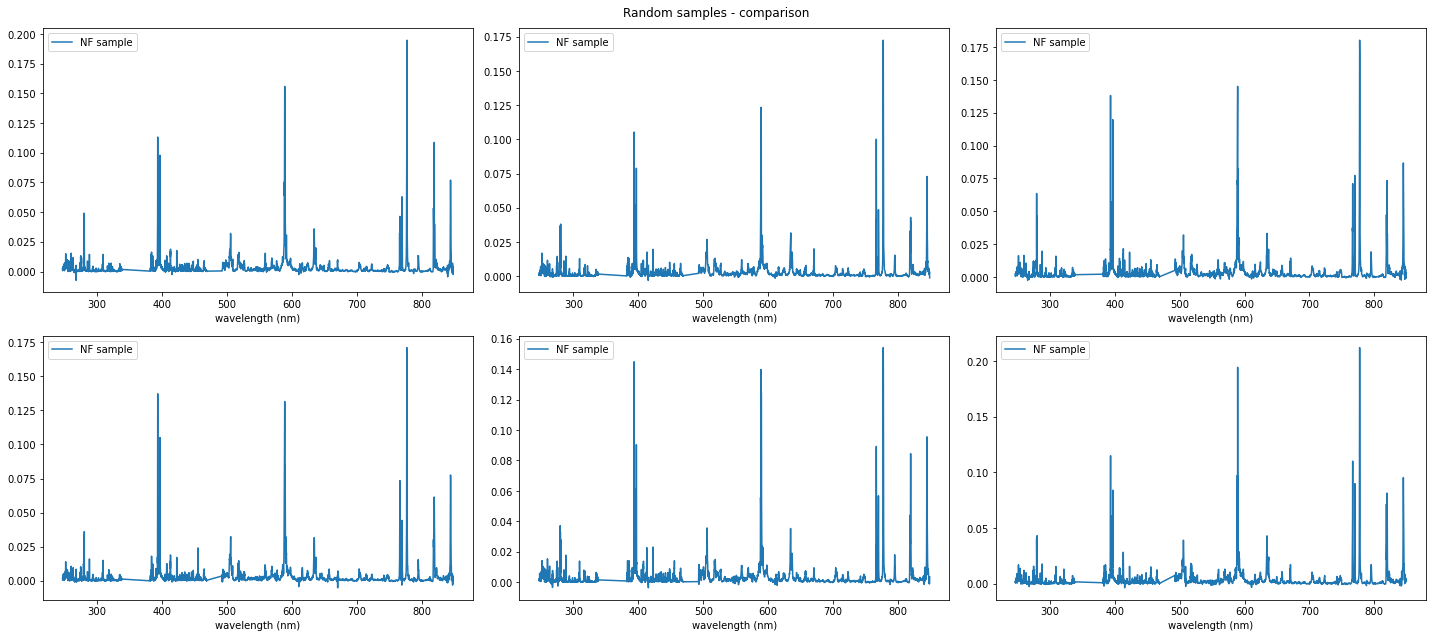

In [4]:
# Load results from NF training
file1 = np.load('data/results.npz') 
calib_data_gaussian = file1['z'] # load calibration data to gaussian (X --> Z)

# Load noise and corresponding LIBS spectra (Z --> X)
noise = file1['noise']
libs_from_noise = file1['forward_flow']

# Plot samples in two random dimensions
#plt.scatter(calib_data_gaussian[:,1], calib_data_gaussian[:,2]) # notice a few outliers
#plt.show()

# Compare an original LIBS sample with one generated with the NF model
# Plot before normalization
fig = plt.figure(figsize=(20, 9), facecolor='white')

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    rr = np.random.randint(0,400)
    #plt.plot(w, calib_data[rr,:], label='original sample')
    plt.plot(w, libs_from_noise[rr,:], label='NF sample')
    #plt.ylim(0,0.25)
    plt.legend()
    plt.xlabel('wavelength (nm)')
plt.suptitle('Random samples - comparison')
fig.tight_layout()
plt.show()

In [5]:
# Load compositions
file2 = np.load('data/calibration_data.npz')
comp = file2['c']
comp.shape

(426, 8)

## Train regressor models (one for each oxide)

In [6]:
# Outlier detection
# from sklearn.ensemble import IsolationForest
# out = IsolationForest(random_state=1).fit(calib_data)
# ind = out.predict(calib_data)==1

In [7]:
# throw away ouliers 
# calib_data_out = calib_data[ind]
# comp_out = comp[ind]

# calib_data = calib_data_out # save
# comp = comp_out
# print(calib_data.shape, comp.shape)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from tqdm import tqdm
import time

start_time = time.time()
# train 8 models, one for each oxide
# split = 400

# # # PLS
# max_comp = 50
# models_best, scores_best = [0]*comp.shape[1], [0]*comp.shape[1]
# for j in range(comp.shape[1]):
#     curr_best = 0
#     for i in range(max_comp):
#         n_comp = i+1
#         pls = PLSRegression(n_components=n_comp, max_iter=3000, tol=1e-4)
#         pls.fit(calib_data[:split], comp[:split,j])
#         score = pls.score(calib_data[split:], comp[split:,j]) # test on remaining samples
#         if score > curr_best:
#             curr_best = score
#             models_best[j] = pls
#             scores_best[j] = curr_best    
#     print(curr_best)

#NN
models_best, scores_best = [], []

for j in tqdm(range(comp.shape[1]), desc='Training of NNs'):
    
    print('Iteration: {}'.format(j+1))
    X_train, X_test, y_train, y_test = train_test_split(calib_data, comp, test_size=0.33, random_state=44, shuffle=True)

    mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=500).fit(X_train, y_train[:,j])
    score = mlp.score(X_test, y_test[:,j]) # test on remaining samples
          
    models_best.append(mlp)
    scores_best.append(score)
    print('Training of model {} completed'.format(j+1))
    print('Score:', score)
    print('')
    
print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

Training of NNs:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration: 1


Training of NNs:  12%|█▎        | 1/8 [05:00<35:05, 300.84s/it]

Training of model 1 completed
Score: 0.8376719839509064

Iteration: 2


Training of NNs:  25%|██▌       | 2/8 [05:38<22:10, 221.82s/it]

Training of model 2 completed
Score: 0.10833498797721985

Iteration: 3


Training of NNs:  38%|███▊      | 3/8 [08:10<16:44, 200.81s/it]

Training of model 3 completed
Score: 0.8893969243234464

Iteration: 4


Training of NNs:  50%|█████     | 4/8 [11:06<12:53, 193.40s/it]

Training of model 4 completed
Score: 0.7955442832349815

Iteration: 5


Training of NNs:  62%|██████▎   | 5/8 [12:36<08:07, 162.34s/it]

Training of model 5 completed
Score: 0.9064084365322842

Iteration: 6


Training of NNs:  75%|███████▌  | 6/8 [14:25<04:52, 146.49s/it]

Training of model 6 completed
Score: 0.9646454016176467

Iteration: 7


Training of NNs:  88%|████████▊ | 7/8 [15:43<02:06, 126.05s/it]

Training of model 7 completed
Score: 0.8969630519059199

Iteration: 8


Training of NNs: 100%|██████████| 8/8 [16:43<00:00, 125.44s/it]

Training of model 8 completed
Score: 0.6732440955653337

--- Total training time - 16.726 minutes ---


In [9]:
scores_best

[0.8376719839509064,
 0.10833498797721985,
 0.8893969243234464,
 0.7955442832349815,
 0.9064084365322842,
 0.9646454016176467,
 0.8969630519059199,
 0.6732440955653337]

In [10]:
# Check outliers manually and remove them (for titanum and sodium)

In [11]:
# For PLS only
#for i in range(comp.shape[1]):
#    print('# of comp. for model {}: {}'.format(i+1, models_best[i].get_params()['n_components']))

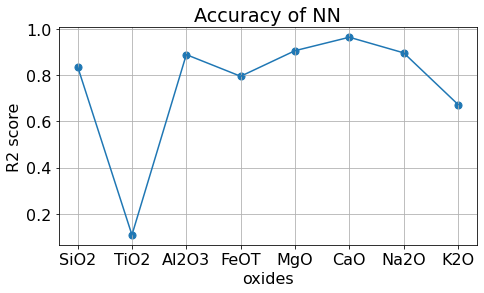

In [12]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']
plt.figure(figsize=(7.5,4))
plt.rcParams.update({'font.size': 16})
plt.plot(oxides, scores_best)
plt.scatter(oxides, scores_best, s=50)
plt.ylabel('R2 score')
plt.xlabel('oxides')
plt.grid()
plt.title('Accuracy of NN')
plt.show()

### Plot oxide weight value vs residual (squared)

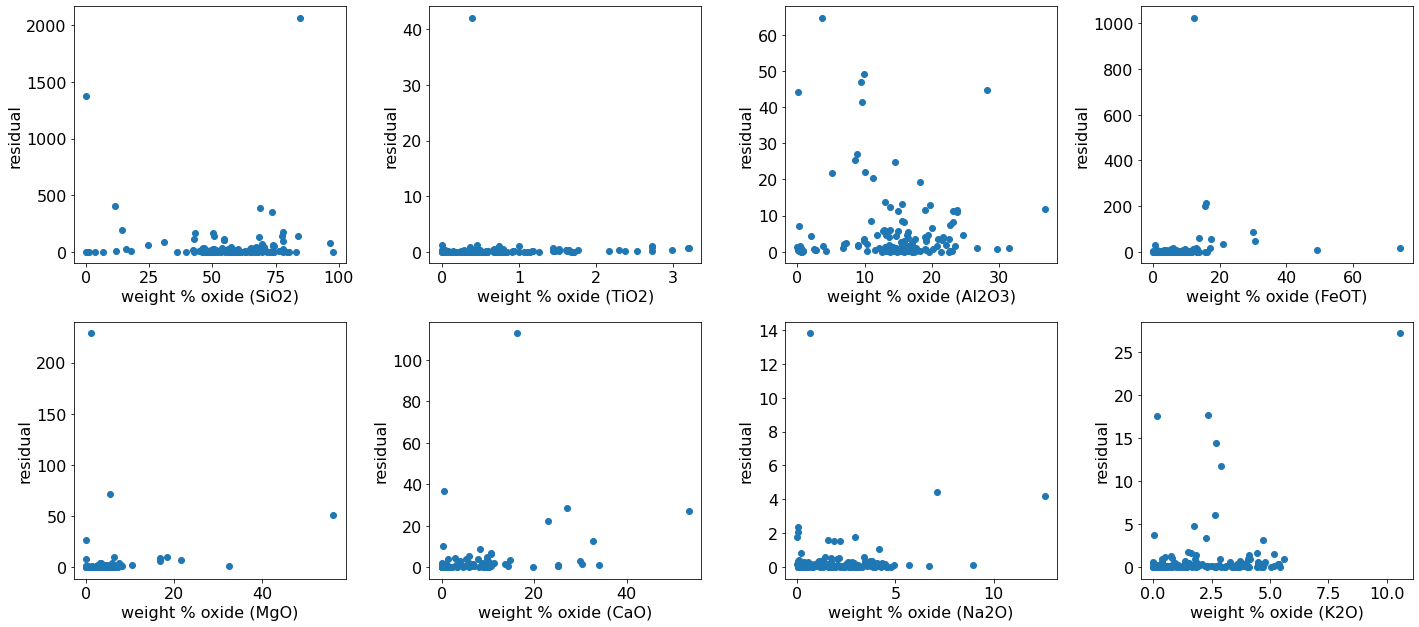

In [13]:
fig = plt.figure(figsize=(20,9), facecolor='white')

for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test)
    res = (nn_pred - y_test[:,i])**2
    plt.scatter(y_test[:,i], res)
    plt.ylabel('residual')
    plt.xlabel('weight % oxide ({})'.format(oxides[i]))
fig.tight_layout()
plt.show()

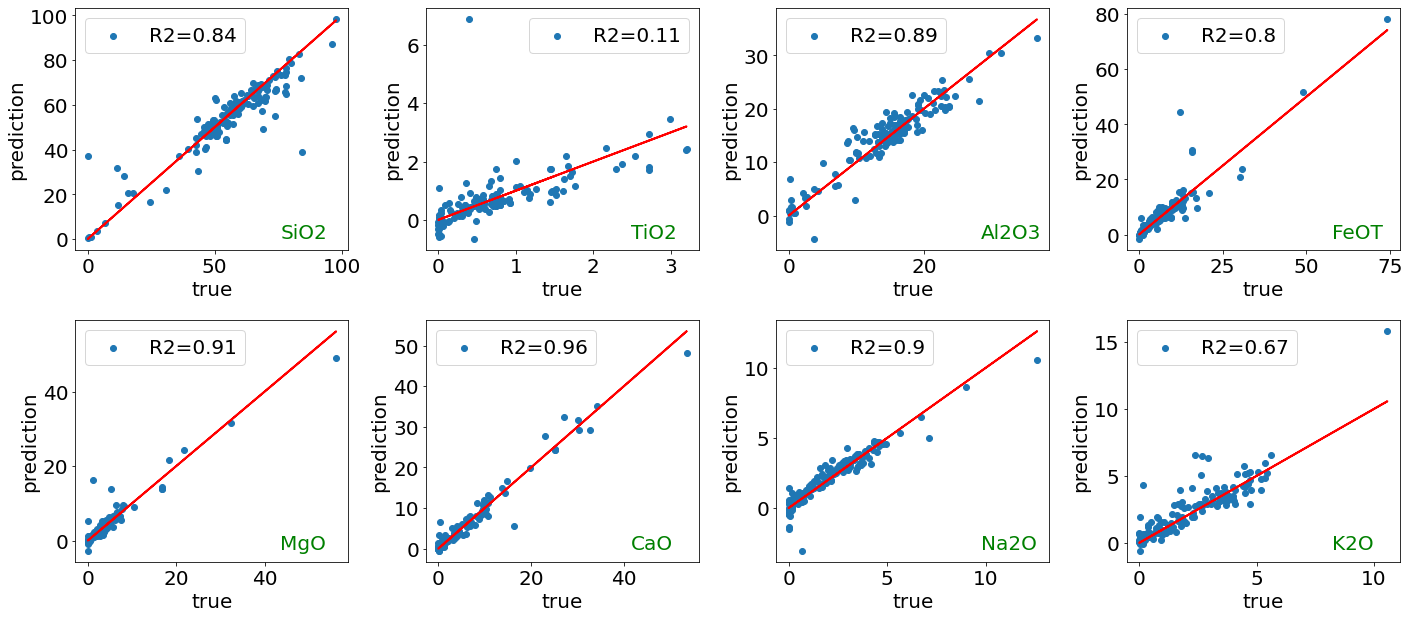

In [14]:
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,9), facecolor='white')
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test)
    rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
    
    plt.scatter(y_test[:,i], nn_pred, label='R2={}'.format(round(scores_best[i], 2)))
    plt.plot(y_test[:,i], y_test[:,i], c='r', linewidth=2)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.legend()
    plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), c='g', xycoords='axes fraction')
fig.tight_layout()
plt.savefig('results/true_vs_prediction.png', dpi=400)
plt.show()

### Detect outliers manually

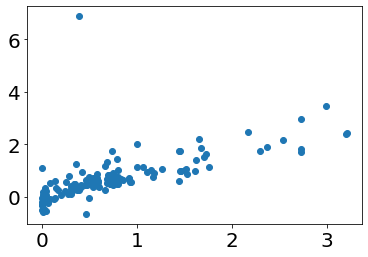

In [15]:
# First outlier
nn_pred = models_best[1].predict(X_test)
plt.scatter(y_test[:,1], nn_pred, label='R2={}'.format(round(scores_best[1], 2)))
plt.show()

In [16]:
ind1 = np.argmax(models_best[1].predict(X_test))
print(ind1)

111


In [17]:
# remove outlier
X_test_new = np.delete(X_test, obj=ind1, axis=0)
y_test_new = np.delete(y_test, obj=ind1, axis=0)

In [18]:
print(X_test_new.shape)
print(y_test_new.shape)

(140, 5606)
(140, 8)


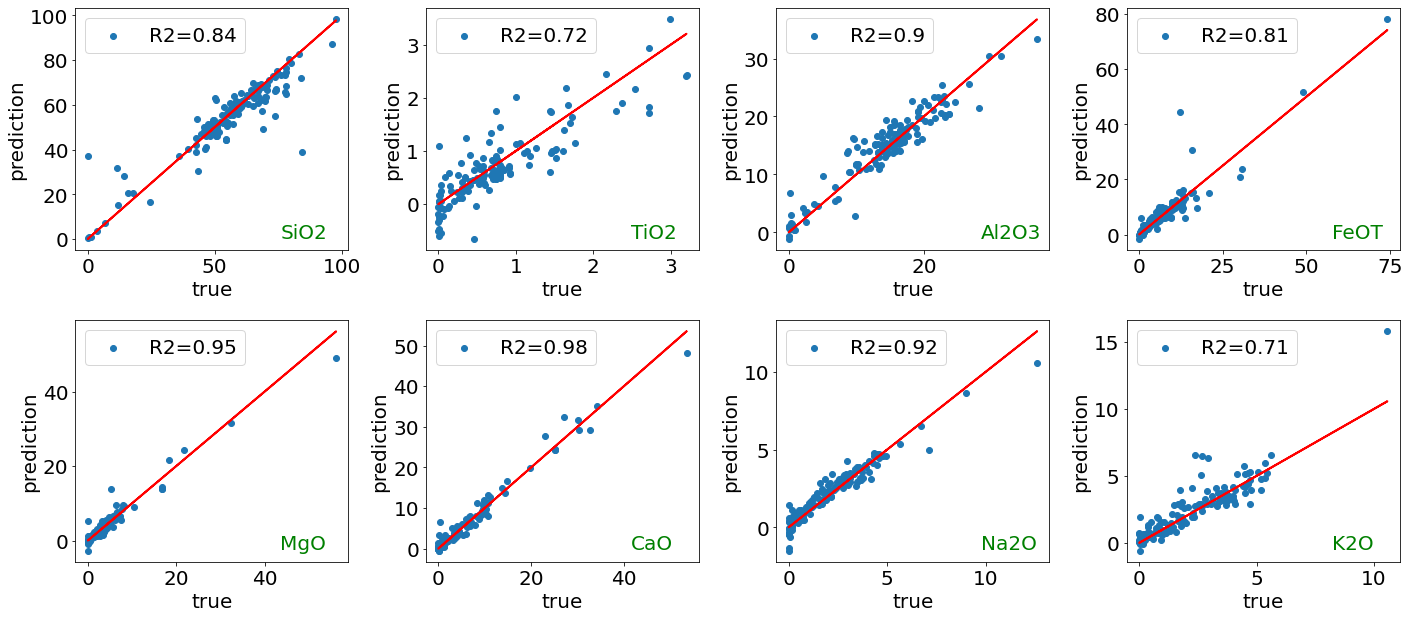

In [19]:
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,9), facecolor='white')
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test_new)
    #rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
    score = models_best[i].score(X_test_new, y_test_new[:,i])
    plt.scatter(y_test_new[:,i], nn_pred, label='R2={}'.format(round(score, 2)))
    plt.plot(y_test_new[:,i], y_test_new[:,i], c='r', linewidth=2)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.legend(loc='upper left')
    plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), c='g', xycoords='axes fraction')
fig.tight_layout()
plt.savefig('results/true_vs_prediction-no-outliers.png', dpi=400)
plt.show()

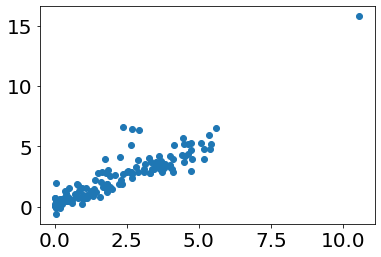

In [20]:
# Second outlier

nn_pred = models_best[7].predict(X_test_new)
plt.scatter(y_test_new[:,7], nn_pred, label='R2={}'.format(round(scores_best[7], 2)))
plt.show()

In [21]:
ind2 = np.argmax(models_best[7].predict(X_test_new))
ind2

79

In [22]:
# remove outlier
X_test_new = np.delete(X_test_new, obj=ind2, axis=0)
y_test_new = np.delete(y_test_new, obj=ind2, axis=0)

In [41]:
X_test_new.shape

(139, 5606)

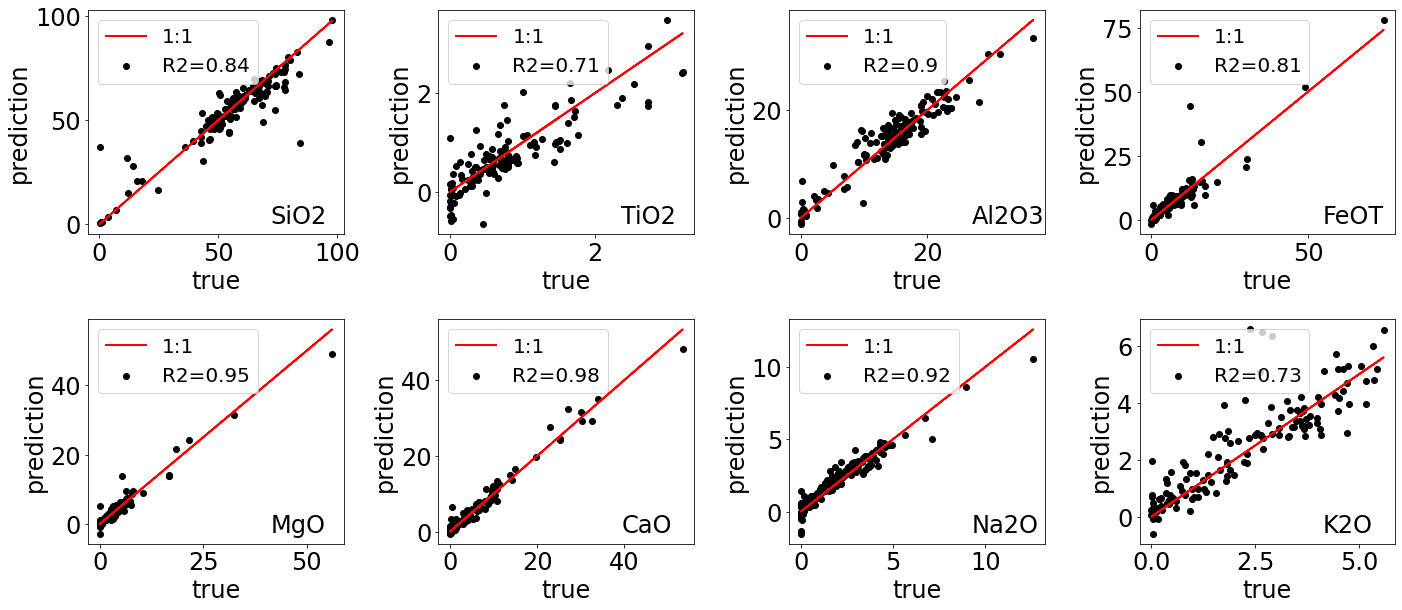

In [144]:
from sklearn.metrics import mean_squared_error
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']

plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(20,9), facecolor='white')
save_pred = []
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    nn_pred = models_best[i].predict(X_test_new)
    save_pred.append(nn_pred)
    #rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
    score = models_best[i].score(X_test_new, y_test_new[:,i])
    plt.scatter(y_test_new[:,i], nn_pred, c='k', label='R2={}'.format(round(score, 2)))
    plt.plot(y_test_new[:,i], y_test_new[:,i], c='r', linewidth=2, label='1:1')
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.legend(loc='upper left', fontsize=20)
    plt.annotate('{}'.format(oxides[i]), xy=(0.715, 0.05), c='k', xycoords='axes fraction', fontsize=24)
fig.tight_layout()
plt.savefig('results/true_vs_prediction-no-outliers_2.png', dpi=500)
plt.show()

In [ ]:
# # Third outlier 

# nn_pred = models_best[1].predict(X_test)
# plt.scatter(y_test[:,1], nn_pred, label='R2={}'.format(round(scores_best[1], 2)))
# plt.show()
# ind3 = np.argmax(models_best[1].predict(X_test))
# ind3

In [ ]:
# # remove outlier
# X_test = np.delete(X_test, obj=ind3, axis=0)
# y_test = np.delete(y_test, obj=ind3, axis=0)

In [ ]:
# from sklearn.metrics import mean_squared_error

# plt.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=(20,9), facecolor='white')
# for i in range(8):
#     ax = plt.subplot(2,4,i+1)
#     nn_pred = models_best[i].predict(X_test)
#     #rms = mean_squared_error(y_test[:,i], nn_pred, squared=False)
#     score = models_best[i].score(X_test, y_test[:,i])
#     plt.scatter(y_test[:,i], nn_pred, label='R2={}'.format(round(score, 2)))
#     plt.plot(y_test[:,i], y_test[:,i], c='r', linewidth=2)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.legend()
#     plt.annotate('{}'.format(oxides[i]), xy=(0.75, 0.05), xycoords='axes fraction')
# fig.tight_layout()
# plt.savefig('results/true_vs_prediction-no-outliers.png', dpi=400)
# plt.show()

In [ ]:
# Check that oxides percentages add up to 100% (approx.)
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12,6))
save_pred_array = np.array((save_pred))
plt.ylabel('sum of percentages')
plt.xlabel('samples')
plt.plot(np.sum(comp, axis=1), label='comp. of train data')
plt.plot(np.sum(save_pred_array, axis=0), label='predicted comps with NNs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# save data sets with no outliers
np.savez('Train-data-no-outliers.npz', x_tr=X_train, y_tr=y_train, x_te=X_test_new, y_te=y_test_new)

In [ ]:
# Load test data
file10 = np.load('Train-data-no-outliers.npz')  
X_test_new = file10['x_te'] 
y_test_new = file10['y_te']
X_train= file10['x_tr'] 
y_train = file10['y_tr']

### Bootstrapping

In [ ]:
# %%
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

start_time = time.time()

np.random.seed(42)

#%% Load and process data
ox_wt_names = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']

boot_preds_all = []

# run for first 4 oxides
for i in range(4):
    # %% Settings
    n_boot = 100    # number of bootstrap replications
    size_boot = 280 # should probably be close to y_train.shape[0]
    y_ind = i+4      # which oxide weight index

    #%% Bootstrap NN for one oxide wt
    boot_preds, scores = [], []
    parameters = {'n_components': np.arange(1, 15)}

    for bi in tqdm(range(n_boot), desc='Bootstrap resampling'):
        # Draw bootstrap sample
        boot_ind = np.random.choice(X_train.shape[0], size=size_boot, replace=True)
        x_boot = X_train[boot_ind, :]
        y_boot = y_train[boot_ind, y_ind]

        # Fit model
        mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=500).fit(x_boot, y_boot)
        scores.append(mlp.score(X_test_new, y_test_new[:, y_ind])) # test on remaining samples

        # Get residuals
        resid = y_boot - mlp.predict(x_boot).squeeze()

        # construct PLS models for predicting residuals
        #pls_res = PLSRegression(scale=False)
        #cvres = GridSearchCV(pls_res, parameters).fit(mlp.predict(x_boot).reshape(-1, 1), resid.reshape(-1, 1)**2)
        #n_comp = cvres.best_params_['n_components']
        #print('Iteration {}: PLS component: {}'.format(bi+1, n_comp))
        pls_fit = PLSRegression(scale=False, n_components=1).fit(mlp.predict(x_boot).reshape(-1, 1), resid.reshape(-1, 1)**2)

        # TODO: as a tweak, bin residuals? or estimate heteroskedastic variance trend...?
        # some residuals much higher (for high SiO2, maybe) so could be overly conservative

        # Predicted squared residual
        psr = pls_fit.predict(mlp.predict(X_test_new).reshape(-1, 1))
        psr[psr<0] = 0

        boot_preds.append((mlp.predict(X_test_new).squeeze() + (np.random.normal(0,np.sqrt(psr))).squeeze()))
        #boot_preds.append((mlp.predict(X_test_new).squeeze() + (np.random.choice((-1, 1)) * np.sqrt(psr)).squeeze()))
        #boot_preds.append(mlp.predict(X_test_new).squeeze() + np.random.choice(resid, size=X_test_new.shape[0]))

    # %%
    boot_preds = np.array(boot_preds) # shape (n_boot, n_test)
    boot_preds_all.append(boot_preds)
    
print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

In [ ]:
#np.savez('data/boot_results_first_4.npz', boot=boot_preds_all)
np.savez('data/boot_results_second_4.npz', boot=boot_preds_all)

In [ ]:
# %%
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(6, 4))
plt.plot(scores)
plt.scatter(np.arange(0,n_boot,1), scores)
plt.xlabel('Bootstrap repetition')
plt.ylabel(r'$R^2$')

# %%
indices = np.random.choice(boot_preds.shape[1], size=15, replace=True)
fig = plt.figure(figsize=(12, 6))
plt.boxplot(boot_preds[:,indices])
plt.plot(np.arange(1, 15+1), y_test_new[:, y_ind][indices], 'g*', markersize=10)
plt.xlabel('Test set index')
plt.ylabel('Dist. of bootstrap predictions')
#plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
plt.annotate('{}'.format(ox_wt_names[y_ind]), xy=(0.9, 0.91), c='k', xycoords='axes fraction', fontsize=25)
fig.tight_layout()
plt.savefig('results/bootstrapping_{}.png'.format(ox_wt_names[y_ind], dpi=400))
plt.show()
# %%

### Coverage

In [ ]:
# Compute coverage
q_low, q_high = 0.025, 0.975
quant = np.quantile(boot_preds, [q_low, q_high], axis=0)

covered = 0
for i in range(boot_preds.shape[1]):
    if quant[0][i] < y_test_new[i, y_ind] < quant[1][i]:
        covered += 1
        
print('Coverage: {}%'.format(round(covered/boot_preds.shape[1] * 100, 3)))

In [ ]:
covered

### Post-processing

In [145]:
# Load results
file20 = np.load('data/boot_results_first_4.npz')  
res1 = file20['boot'] 
file30 = np.load('data/boot_results_second_4.npz')  
res2 = file30['boot'] 

In [146]:
res_all = np.concatenate((res1,res2))
res_all.shape

(8, 100, 139)

In [181]:
#compute coverage
cov = []
for j in range(8):
    # Compute coverage
    q_low, q_high = 0.025, 0.975
    quant = np.quantile(res_all[j], [q_low, q_high], axis=0)

    covered = 0
    for i in range(res_all[j].shape[1]):
        if quant[0][i] < y_test_new[i, j] < quant[1][i]:
            covered += 1
    cov.append(round(covered/res_all[j].shape[1] * 100, 3))

In [148]:
cov

[84.892, 98.561, 86.331, 86.331, 86.331, 96.403, 93.525, 89.928]

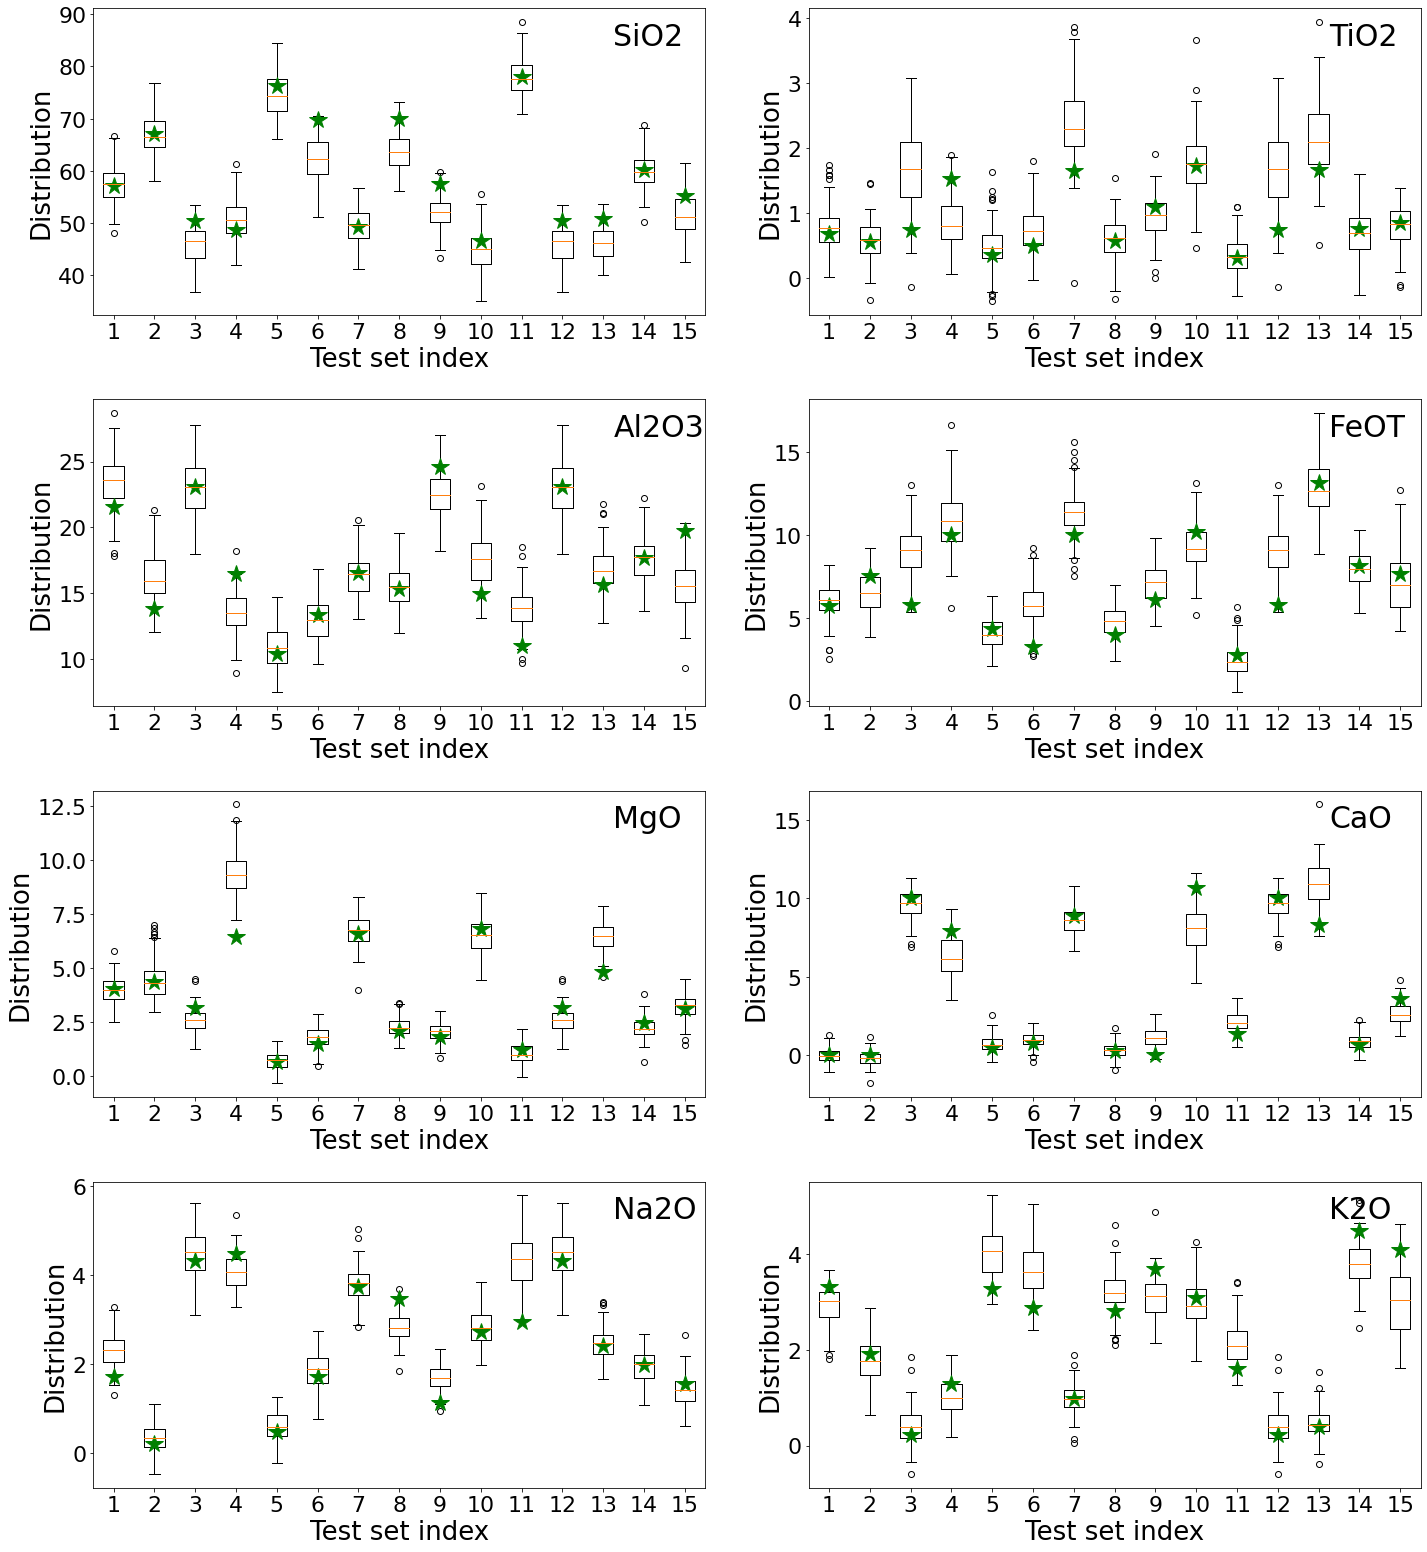

In [185]:
fig = plt.figure(figsize=(20, 22), facecolor='white')
ox_wt_names = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

plt.rcParams.update({'font.size': 22})
np.random.seed(16)
indices = np.random.choice(res_all[0].shape[1], size=15, replace=True)
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    plt.boxplot(res_all[i][:,indices])
    plt.plot(np.arange(1, 15+1), y_test_new[:, i][indices], 'g*', markersize=18)
    plt.xlabel('Test set index', fontsize=26)
    plt.ylabel('Distribution', fontsize=26)
    #plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
    plt.annotate('{}'.format(ox_wt_names[i]), xy=(0.85, 0.88), c='k', xycoords='axes fraction', fontsize=30)

fig.tight_layout()
plt.savefig('results/bootstrapping_validation_v3.png', dpi=500)
plt.show()

In [223]:
index

121

In [228]:
res_all[:][:,99].T.shape

(139, 8)

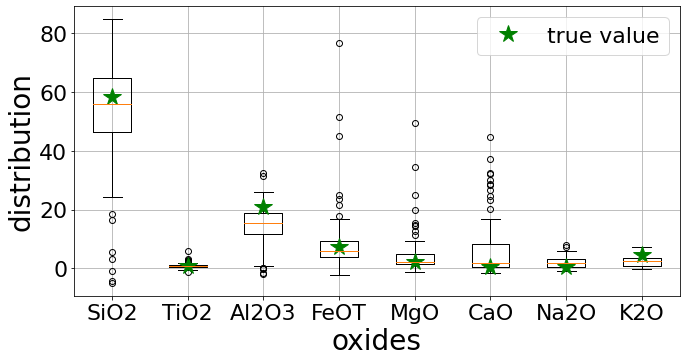

In [286]:
# Show 1 figure with all 8 oxides
fig = plt.figure(figsize=(10,5.5), facecolor='white')

plt.rcParams.update({'font.size': 22})
#np.random.seed(17)
index = np.random.choice(100, size=1, replace=True)[0]
#index = 99

plt.boxplot(res_all[:][:,index].T)
for i in range(8):
    if i ==0:
        plt.plot(i+1, y_test_new[:, i][index].reshape(1,), 'g*', markersize=18, label='true value')
    else:
        plt.plot(i+1, y_test_new[:, i][index].reshape(1,), 'g*', markersize=18)

plt.legend()
plt.ylabel('distribution', fontsize=28)
plt.xlabel('oxides', fontsize=28)
plt.xticks(ticks=np.arange(1,9),labels=ox_wt_names)
plt.grid()
fig.tight_layout()
plt.savefig('results/bootstrapping_validation_all_oxides_in_one.png', dpi=500)
plt.show()

## Uncertainty quantification (UQ)

### Choose nearest neighbors and compute uncertainty of predictions

In [ ]:
print(noise.shape, libs_from_noise.shape)

In [ ]:
fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(noise[:,0], noise[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Noise')
plt.subplot(1,2,2)
plt.plot(w, libs_from_noise[111,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('normalized intensity (a.u.)')
plt.ylim(-0.01,0.4)
plt.title('Random sample (NF)')
fig.tight_layout()
plt.show()

In [ ]:
# Choose one point and find its k-nearest neighbors
n_neighbors = 15
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, p=2)
knn.fit(noise)

rand_sample = np.random.randint(0,noise.shape[0])
nn = knn.kneighbors(X=noise[rand_sample,:].reshape(1, -1), n_neighbors=n_neighbors, return_distance=False) # indices

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.scatter(noise[:,0], noise[:,1], s=15, label='samples')
plt.scatter(noise[rand_sample,0], noise[rand_sample,1], s=120, c='yellow', label='reference sample')
plt.scatter(noise[nn,0], noise[nn,1], s=50, c='r', label='knn')
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('knn (Euclidean distance)')
plt.legend()
plt.show()

In [ ]:
# Predict compositions for samples and its neighbors with the pretrained PLS models
pred = [] # list 
for i in range(comp.shape[1]):
    pred.append(models_best[i].predict(libs_from_noise[nn].reshape(nn.shape[1], libs_from_noise.shape[1])))

In [ ]:
pred_ar = np.array((pred)).reshape(comp.shape[1], nn.shape[1]) # convert list to numpy array
pred_ar.shape

In [ ]:
# should give ~100%
np.sum(pred_ar, axis=0)

In [ ]:
# Compute mean and max-min
mean = np.mean(pred_ar, axis=1)
p_max = np.amax(pred_ar, axis=1)
p_min = np.amin(pred_ar, axis=1)
std = np.std(pred_ar, axis=1)

In [ ]:
# Plot distributions of predictions
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(8,5))
plt.plot(oxides, mean, label=r'$\mu$')
plt.scatter(oxides, mean, c='r', s=60)
plt.fill_between(oxides, p_min, p_max, alpha=0.2, label=r'$\pm 2\sigma$')
plt.errorbar(oxides, mean, yerr=2*std, fmt='.k')
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.title('Prediction (nn={})'.format(n_neighbors))
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()
plt.savefig('results/prediction_knn_{}.png'.format(n_neighbors), dpi=300)
plt.show()

In [ ]:
# Check variance in calibration data

mean_cal = np.mean(comp, axis=0)
min_cal = np.amin(comp, axis=0)
max_cal = np.amax(comp, axis=0)


plt.figure(figsize=(7,5))
plt.plot(oxides, mean_cal, label=r'$\mu$')
plt.scatter(oxides, mean_cal, c='r', s=60)
plt.fill_between(oxides, min_cal, max_cal, alpha=0.2, label='min to max')
#plt.errorbar(oxides, mean_cal, yerr=2*std_cal, fmt='.k')
#plt.errorbar(oxides, mean, yerr=p_min + p_max, fmt='-o')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()

## Dimension reduction and normalizing flows in spectral latent space

In [42]:
data_for_dr = file['y_train']
data_for_dr.shape

(626, 5606)

In [43]:
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

parameters = {'n_components': np.arange(5, 16)}
r2 = []
for i in parameters['n_components']:
    #model = FastICA(n_components=i, random_state=0).fit(data_for_dr)
    data_for_dr[data_for_dr<0] = 0 # for NMF only
    model = NMF(n_components=i, random_state=0).fit(data_for_dr)
    
    transf = model.transform(data_for_dr)
    recon = model.inverse_transform(transf)
    r2.append(r2_score(data_for_dr, recon))

/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/Users/katianakontolati/opt/anaconda3/lib/python3.7/site-packages/sklear

In [44]:
print('best accuracy is: {} for {} components'.format(round(np.amax(r2),3), parameters['n_components'][np.argmax(r2)]))

best accuracy is: 0.8 for 15 components


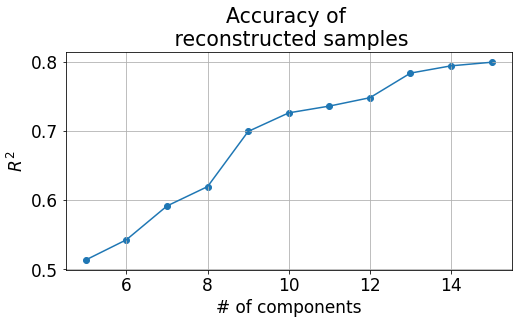

In [45]:
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(8,4))
plt.plot(parameters['n_components'], r2)
plt.scatter(parameters['n_components'], r2)
plt.ylabel(r'$R^2$')
plt.xlabel('# of components')
plt.title('Accuracy of \n reconstructed samples')
plt.grid()
plt.show()

Text(0.5, 0, 'ICA comp. 6')

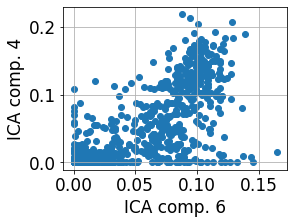

In [46]:
plt.figure(figsize=(4,3))
plt.scatter(transf[:,2], transf[:,10])
plt.ylabel('ICA comp. 4')
plt.grid()
plt.xlabel('ICA comp. 6')

In [47]:
np.savez('data/dr_samples.npz', dr=transf)
# Copy this sample to the NF code directory
subprocess.run(["cp", "data/dr_samples.npz", "/Users/katianakontolati/PycharmProjects/pytorch-flows/data/chemcam/"])

CompletedProcess(args=['cp', 'data/dr_samples.npz', '/Users/katianakontolati/PycharmProjects/pytorch-flows/data/chemcam/'], returncode=0)

In [274]:
cal_nmf = transf[:426,:]
cal = calib_data

In [275]:
cal_nmf.shape

(426, 15)

In [282]:
# Train NN models on the NMF latent space (comment out if you're running NN in the original space)
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from tqdm import tqdm
import time

start_time = time.time()

#NN
models_best, scores_best = [], []

for j in tqdm(range(comp.shape[1]), desc='Training of NNs'):
    
    print('Iteration: {}'.format(j+1))
    X_train, X_test, y_train, y_test = train_test_split(cal_nmf, comp, test_size=0.33, random_state=44, shuffle=True)

    mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=(20,10,5)).fit(X_train, y_train[:,j])
    score = mlp.score(X_test, y_test[:,j]) # test on remaining samples
          
    models_best.append(mlp)
    scores_best.append(score)
    print('Training of model {} completed'.format(j+1))
    print('Score:', score)
    print('')
    
print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

Training of NNs:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration: 1


Training of NNs:  12%|█▎        | 1/8 [00:01<00:12,  1.75s/it]

Training of model 1 completed
Score: 0.6118017496850349

Iteration: 2


Training of NNs:  25%|██▌       | 2/8 [00:02<00:09,  1.55s/it]

Training of model 2 completed
Score: -40.59176324715149

Iteration: 3


Training of NNs:  38%|███▊      | 3/8 [00:04<00:08,  1.71s/it]

Training of model 3 completed
Score: 0.6535055634522988

Iteration: 4


Training of NNs:  50%|█████     | 4/8 [00:06<00:06,  1.67s/it]

Training of model 4 completed
Score: -0.17234104928737048

Iteration: 5


Training of NNs:  62%|██████▎   | 5/8 [00:07<00:04,  1.56s/it]

Training of model 5 completed
Score: 0.8949834044183487

Iteration: 6


Training of NNs:  75%|███████▌  | 6/8 [00:09<00:02,  1.46s/it]

Training of model 6 completed
Score: 0.9530316984328571

Iteration: 7


Training of NNs:  88%|████████▊ | 7/8 [00:10<00:01,  1.41s/it]

Training of model 7 completed
Score: 0.8256974625480209

Iteration: 8


Training of NNs: 100%|██████████| 8/8 [00:11<00:00,  1.45s/it]

Training of model 8 completed
Score: 0.5229775289429411

--- Total training time - 0.194 minutes ---


### Train NF model in pycharm (pytorch-flows package)

In [48]:
# Get results from trained NF model
subprocess.run(["cp", "/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results_dr.npz", "data/"])

CompletedProcess(args=['cp', '/Users/katianakontolati/PycharmProjects/pytorch-flows/results/results_dr.npz', 'data/'], returncode=0)

In [49]:
dr_file = np.load('data/results_dr.npz')  
noise_dr = dr_file['noise'] 
samples_dr = dr_file['forward_flow'] # get actual samples from NF model

In [50]:
# Check NF samples with ICA inverse map
nf_samples_inv_dr = model.inverse_transform(samples_dr)
nf_samples_inv_dr.shape

(2000, 5606)

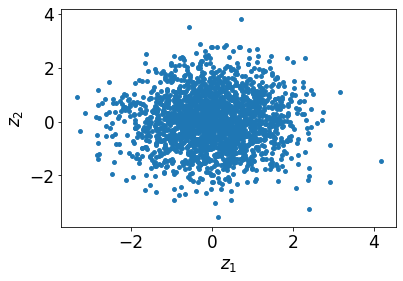

In [51]:
# Plot noise
plt.scatter(noise_dr[:,0], noise_dr[:,1], s=15)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.show()

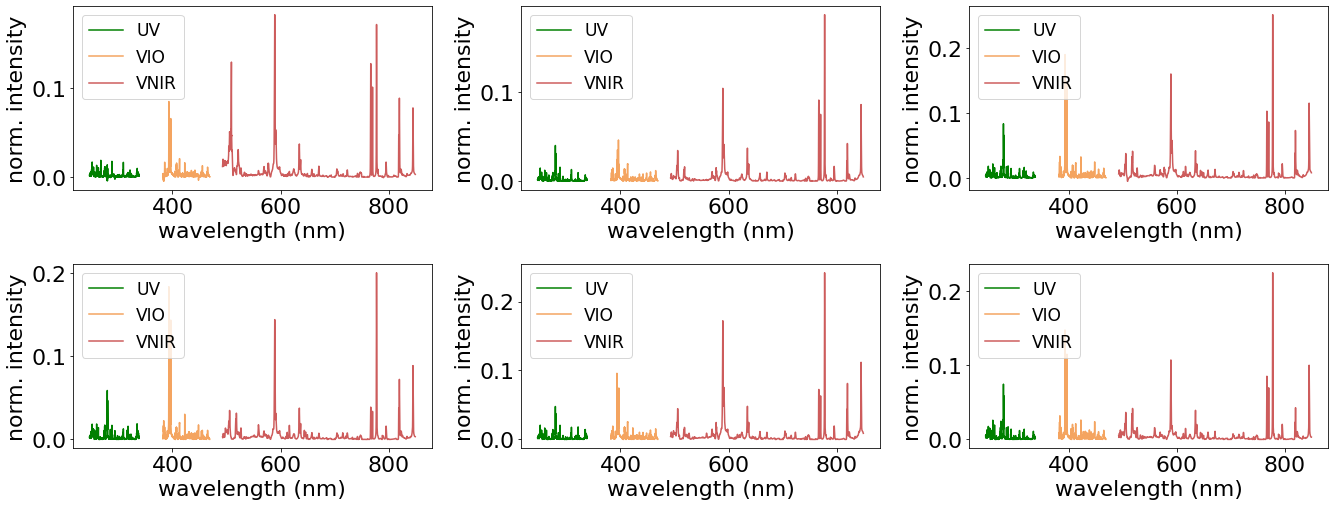

In [143]:
# Plot random samples
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(19, 7.5), facecolor='white')
np.random.seed(10)
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    rr = np.random.randint(0,nf_samples_inv_dr.shape[0]-1)
    
    data_uv_ = nf_samples_inv_dr[rr, :wav_uv.shape[0]]
    data_vio_ = nf_samples_inv_dr[rr, wav_uv.shape[0]: wav_uv.shape[0] + wav_vio.shape[0]]
    data_vnir_ = nf_samples_inv_dr[rr, wav_uv.shape[0] + wav_vio.shape[0]:]
    
    plt.plot(wav_uv, data_uv_, c='green', label='UV')
    plt.plot(wav_vio, data_vio_, c='sandybrown', label='VIO')
    plt.plot(wav_vnir, data_vnir_, c='indianred', label='VNIR')

    #plt.ylim(0,0.25)
    plt.legend(loc='upper left', fontsize=17)
    plt.ylabel('norm. intensity')
    plt.xlabel('wavelength (nm)')
#plt.suptitle('NF samples via inverse NMF')
#ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),
#          fancybox=True, shadow=True, ncol=3)
fig.tight_layout()
plt.savefig('results/random_NF_samples.png', dpi=500)
plt.show()

In [ ]:
#### SKIP the next 4 cells if you haven't trained the NN regression models
# Predict compositions for generated samples
comp_pred_dr = []
for i in range(8):
    nn_pred = models_best[i].predict(nf_samples_inv_dr)
    comp_pred_dr.append(nn_pred)
    
comp_pred_dr_array = np.array(comp_pred_dr)

In [ ]:
fig = plt.figure(figsize=(10, 5), facecolor='white')
plt.scatter(np.arange(0,2000), np.sum(comp_pred_dr_array, axis=0))
plt.plot(np.arange(0,2000), np.ones(2000)*100, c='r')
plt.ylim(0,140)
plt.ylabel('sum of percentages')
plt.xlabel('sample index')
plt.show()

In [ ]:
mean_dr = np.mean(comp_pred_dr_array, axis=1)
std_dr = np.std(comp_pred_dr_array, axis=1)
min_dr = np.amin(comp_pred_dr_array, axis=1)
max_dr = np.amax(comp_pred_dr_array, axis=1)

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(oxides, mean_dr, label=r'$\mu$')
plt.scatter(oxides, mean_dr, c='r', s=60)
plt.fill_between(oxides, min_dr, max_dr, alpha=0.2, label='min to max')
plt.xlabel('oxides')
plt.ylabel('percentage')
plt.legend()
plt.grid()

### Bootstrap for generated samples

In [ ]:
nf_test = nf_samples_inv_dr[:1000,:]

In [ ]:
# Bootstrap for NF generated samples
# %%
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

start_time = time.time()

boot_preds_all = []

# run for first 4 oxides
for i in range(4):
    # %% Settings
    n_boot = 100    # number of bootstrap replications
    size_boot = 280 # should probably be close to y_train.shape[0]
    y_ind = i       # which oxide weight index

    np.random.seed(42)

    #%% Load and process data
    ox_wt_names = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O']

    #%% Bootstrap NN for one oxide wt
    boot_preds, scores = [], []
    parameters = {'n_components': np.arange(1, 15)}

    for bi in tqdm(range(n_boot), desc='Bootstrap resampling'):
        # Draw bootstrap sample
        boot_ind = np.random.choice(X_train.shape[0], size=size_boot, replace=True)
        x_boot = X_train[boot_ind, :]
        y_boot = y_train[boot_ind, y_ind]

        # Fit model
        mlp = MLPRegressor(random_state=1, max_iter=3500, activation='relu', hidden_layer_sizes=500).fit(x_boot, y_boot)
        scores.append(mlp.score(X_test_new, y_test_new[:, y_ind])) # test on remaining samples

        # Get residuals
        resid = y_boot - mlp.predict(x_boot).squeeze()

        # Fit model to map predictions to squared residuals
        pls_fit = PLSRegression(scale=False, n_components=1).fit(mlp.predict(x_boot).reshape(-1, 1), resid.reshape(-1, 1)**2)

        # Predicted squared residual
        psr = pls_fit.predict(mlp.predict(nf_test).reshape(-1, 1))
        psr[psr<0] = 0
        boot_preds.append((mlp.predict(nf_test).squeeze() + (np.random.normal(0,np.sqrt(psr))).squeeze()))
        #boot_preds.append((mlp.predict(nf_test).squeeze() + (np.random.choice((-2, -1, 1, 2)) * np.sqrt(psr)).squeeze()))
        #boot_preds.append(mlp.predict(nf_test).squeeze() + np.random.choice(resid, size=nf_test.shape[0]))

    # %%
    boot_preds = np.array(boot_preds) # shape (n_boot, n_test)
    boot_preds_all.append(boot_preds)

print("--- Total training time - %s minutes ---" % round((time.time() - start_time)/60, 3))

In [ ]:
np.savez('data/boot_results_NF_first_4.npz', boot=boot_preds_all)
#np.savez('data/boot_results_second_4.npz', boot=boot_preds_all)

In [ ]:
# %%
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(6, 4))
plt.plot(scores)
plt.scatter(np.arange(0,n_boot,1), scores)
plt.xlabel('Bootstrap repetition')
plt.ylabel(r'$R^2$')

# %%
indices = np.random.choice(boot_preds.shape[1], size=15, replace=True)
fig = plt.figure(figsize=(12, 6))
plt.boxplot(boot_preds[:,indices])
plt.xlabel('Test set index')
plt.ylabel('Dist. of bootstrap predictions')
#plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
#plt.ylim(-0.5,5)
plt.annotate('{}'.format(ox_wt_names[y_ind]), xy=(0.9, 0.91), c='k', xycoords='axes fraction', fontsize=25)
fig.tight_layout()
plt.savefig('results/bootstrapping_for_NF_samples_{}.png'.format(ox_wt_names[y_ind], dpi=400))
plt.show()
# %%

In [ ]:
# try plot with errorbars for 95% CI instead of 50%
q_low, q_high = 0.025, 0.975
quant = np.quantile(boot_preds, [q_low, q_high], axis=0)
mean_boot = np.mean(boot_preds, axis=0)

# try

indices = np.random.choice(boot_preds.shape[1], size=15, replace=True)
fig = plt.figure(figsize=(12, 6))
plt.errorbar(x=np.arange(1,16,1), y=mean_boot[indices], yerr=quant[:,indices], fmt='.k');
plt.boxplot(boot_preds[:,indices])
plt.xlabel('Test set index')
plt.ylabel('Dist. of bootstrap predictions')
#plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
#plt.ylim(-0.5,5)
plt.annotate('{}'.format(ox_wt_names[y_ind]), xy=(0.9, 0.91), c='k', xycoords='axes fraction', fontsize=25)
fig.tight_layout()
plt.show()
# %%

### Post-processing

In [ ]:
# Load results
file40 = np.load('data/boot_results_NF_first_4.npz')  
res1 = file40['boot'] 
file50 = np.load('data/boot_results_NF_second_4.npz')  
res2 = file50['boot'] 

In [ ]:
res_all = np.concatenate((res1,res2))
res_all.shape

In [ ]:
#compute coverage
cov = []
for j in range(8):
    # Compute coverage
    q_low, q_high = 0.025, 0.975
    quant = np.quantile(res_all[j], [q_low, q_high], axis=0)

    covered = 0
    for i in range(res_all[j].shape[1]):
        if quant[0][i] < y_test_new[i, j] < quant[1][i]:
            covered += 1
    cov.append(round(covered/res_all[j].shape[1] * 100, 3))

In [ ]:
cov

In [ ]:
fig = plt.figure(figsize=(20, 22), facecolor='white')

for i in range(8):
    ax = plt.subplot(4,2,i+1)
    indices = np.random.choice(res_all[i].shape[1], size=15, replace=True)
    plt.boxplot(res_all[i][:,indices])
    plt.plot(np.arange(1, 15+1), y_test_new[:, i][indices], 'g*', markersize=10)
    plt.xlabel('Test set index')
    plt.ylabel('Dist. of bootstrap predictions')
    #plt.title('Bootstrap NNs test predictions for %s' % ox_wt_names[y_ind])
    plt.annotate('{}'.format(ox_wt_names[i]), xy=(0.87, 0.91), c='k', xycoords='axes fraction', fontsize=25)

fig.tight_layout()
plt.savefig('results/bootstrapping_application.png', dpi=400)
plt.show()